In [11]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import dask
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import os
from torch import nn
DATA_PATH = Path(os.getenv("DATA_PATH"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Ensure Dask is imported and setup
dask.config.set(scheduler='threads')

# Load dataset with Dask
data_path = DATA_PATH / "sat2/split_stage_data_100hz.nc"
dataset = xr.open_dataset(data_path, chunks={'participant': 1})  # Adjust chunk size as needed
indexer = dataset.event_name.str.contains("accuracy").compute()
# SAT2: Use Dask's parallel processing capabilities
dataset_acc = dataset.where(indexer, drop=True).compute()
del dataset

In [3]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset_acc, 80, norm_min1_to_1
)
del dataset_acc
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# del train_data
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
del val_data
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
del test_data

In [4]:
item = train_dataset.__getitem__(0)[0]

In [22]:
item_squozen = torch.unsqueeze(item, 0).permute(0, 2, 1)

In [23]:
item_squozen.shape

torch.Size([1, 30, 224])

In [14]:
#input, [224,30] or [224, 30, 1] (squozen)
conv = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 3))

In [31]:
cnn = nn.Sequential(
    nn.Conv1d(in_channels=30, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
)

In [32]:
cnn(item_squozen).shape

torch.Size([1, 128, 224])

In [17]:
conv(item_squozen).shape

torch.Size([16, 224, 28])

In [59]:
# model = SAT1GRU(len(train_data.channels), len(train_data.samples), len(train_data.labels))
# model = SAT1Mamba(len(train_data.channels), len(train_data.labels))
model = MambaModel(embed_dim=256, n_channels=30, n_classes=5, n_layers=3, global_pool=True)
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    epochs=10,
    workers=0,
    batch_size=256,
    labels=SAT_CLASSES_ACCURACY,
    weight_decay=0.001,
    label_smoothing=0.1,
    lr=0.001,
    do_spectral_decoupling=False,
)

  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1527
           1       0.69      0.89      0.78      1683
           2       0.92      0.81      0.86      1683
           3       0.93      0.72      0.81      1683
           4       0.88      0.93      0.91      1683

    accuracy                           0.86      8259
   macro avg       0.87      0.86      0.86      8259
weighted avg       0.87      0.86      0.86      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1527
           1       0.81      0.81      0.81      1683
           2       0.94      0.85      0.90      1683
           3       0.87      0.88      0.88      1683
           4       0.88      0.96      0.91      1683

    accuracy                           0.88      8259
   macro avg       0.89      0.89      0.89      8259
weighted avg       0.89      0.88      0.88      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1527
           1       0.86      0.75      0.80      1683
           2       0.93      0.88      0.90      1683
           3       0.85      0.92      0.88      1683
           4       0.85      0.96      0.90      1683

    accuracy                           0.88      8259
   macro avg       0.89      0.89      0.88      8259
weighted avg       0.89      0.88      0.88      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1527
           1       0.76      0.86      0.81      1683
           2       0.98      0.76      0.86      1683
           3       0.87      0.88      0.87      1683
           4       0.87      0.96      0.91      1683

    accuracy                           0.88      8259
   macro avg       0.88      0.88      0.88      8259
weighted avg       0.88      0.88      0.88      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1527
           1       0.75      0.89      0.82      1683
           2       0.95      0.85      0.90      1683
           3       0.93      0.81      0.87      1683
           4       0.90      0.95      0.92      1683

    accuracy                           0.89      8259
   macro avg       0.89      0.89      0.89      8259
weighted avg       0.89      0.89      0.89      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1527
           1       0.85      0.80      0.82      1683
           2       0.95      0.87      0.91      1683
           3       0.88      0.92      0.90      1683
           4       0.86      0.96      0.91      1683

    accuracy                           0.89      8259
   macro avg       0.90      0.89      0.89      8259
weighted avg       0.90      0.89      0.89      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1527
           1       0.76      0.88      0.81      1683
           2       0.98      0.80      0.88      1683
           3       0.92      0.86      0.89      1683
           4       0.89      0.95      0.92      1683

    accuracy                           0.88      8259
   macro avg       0.89      0.89      0.89      8259
weighted avg       0.89      0.88      0.89      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1527
           1       0.69      0.91      0.78      1683
           2       0.98      0.74      0.85      1683
           3       0.93      0.80      0.86      1683
           4       0.89      0.95      0.92      1683

    accuracy                           0.87      8259
   macro avg       0.89      0.87      0.87      8259
weighted avg       0.88      0.87      0.87      8259



  0%|          | 0/276 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1527
           1       0.74      0.91      0.81      1683
           2       0.97      0.84      0.90      1683
           3       0.93      0.83      0.88      1683
           4       0.91      0.92      0.91      1683

    accuracy                           0.89      8259
   macro avg       0.90      0.89      0.89      8259
weighted avg       0.89      0.89      0.89      8259



[{'0.0': {'precision': 0.9706521739130435,
   'recall': 0.9089058524173028,
   'f1-score': 0.9387647831800263,
   'support': 1965.0},
  '1.0': {'precision': 0.922286448298009,
   'recall': 0.6984435797665369,
   'f1-score': 0.7949072792693053,
   'support': 2056.0},
  '2.0': {'precision': 0.8721461187214612,
   'recall': 0.9289883268482491,
   'f1-score': 0.8996702779086199,
   'support': 2056.0},
  '3.0': {'precision': 0.8319583152409901,
   'recall': 0.9319066147859922,
   'f1-score': 0.8791007111722873,
   'support': 2056.0},
  '4.0': {'precision': 0.8742931709438887,
   'recall': 0.9776264591439688,
   'f1-score': 0.9230769230769231,
   'support': 2056.0},
  'accuracy': 0.8889979389537737,
  'macro avg': {'precision': 0.8942672454234785,
   'recall': 0.88917416659241,
   'f1-score': 0.8871039949214324,
   'support': 10189.0},
  'weighted avg': {'precision': 0.8935850363261627,
   'recall': 0.8889979389537737,
   'f1-score': 0.8866426020731125,
   'support': 10189.0}}]

In [60]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None, class_labels=SAT_CLASSES_ACCURACY)
pred = pred.cpu()

0.8889979389537737


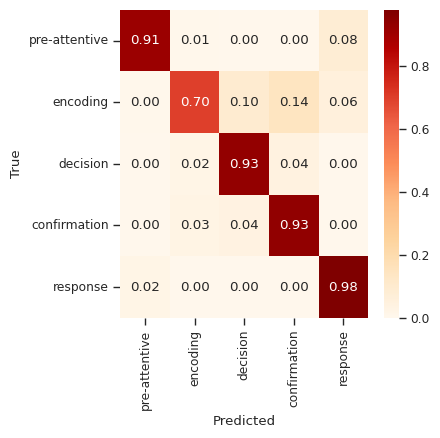

In [61]:
plot_confusion_matrix(true, pred, SAT_CLASSES_ACCURACY)